In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import pickle
import sklearn
import time
from sklearn import metrics
from sklearn import model_selection


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [2]:
%run SharedFunctions.ipynb

Učitava se prethodno pripremljen skup podataka: 

In [3]:
data = pd.read_csv('data/data_longer.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
data.shape

(223453, 9)

### 1. Podela na trening, test, i validacioni skup

In [5]:
# data.head()

In [6]:
X = data['comment_text']
y = data['target']

In [7]:
X_train_validation, X_test, y_train_validation, y_test = \
    model_selection.train_test_split(X, y, test_size=0.33, stratify=y, random_state=7)

X_train, X_validation, y_train, y_validation =\
    model_selection.train_test_split(X_train_validation, y_train_validation, test_size=0.2, stratify=y_train_validation, random_state=7)

In [8]:
X_train.shape, X_validation.shape, X_test.shape

((119770,), (29943,), (73740,))

In [9]:
y_train.shape, y_validation.shape, y_test.shape

((119770,), (29943,), (73740,))

### 2. Tokenizacija I vektorizacija teksta

In [11]:
# uzima se recimo 20000 najfrekventinijh reci
max_features = 20000

# max duzina
max_len = 100

In [12]:
word_index, tokenizer = get_vocabulary(max_features, X_train, 'tokenizer_binary.pickle')

In [13]:
print('Broj jedinstvenih reci:', len(word_index))

Broj jedinstvenih reci: 201164


Sada pravimo skupove za trening, test i validaciju sa vektorizovanim tekstom

In [14]:
X_train_transformed = to_sequence(X_train, max_len, tokenizer)
X_test_transformed = to_sequence(X_test, max_len, tokenizer)
X_validation_transformed = to_sequence(X_validation, max_len, tokenizer)

In [15]:
X_train.shape, X_test.shape, X_validation.shape

((119770,), (73740,), (29943,))

In [16]:
X_train_validation_transformed = to_sequence(X_train_validation, max_len, tokenizer)

Kreira se matrica ugnjezdavanja

In [17]:
embedding_matrix = create_embedding_matrix(word_index, max_len)

### 3. Selekcija i evaluacija modela

In [18]:
# Posto su klasa nebalansirane, potrebno je dodeliti im tezine
# tako da se vise kaznjava pogresna klasifikacija manjinske klase

weights = get_weights(y_train_validation, 2)
weights

{0: 0.5558967465969598, 1: 4.97253221735087}

Za podešavanje hiperparametara koristiće se randomizovana unakrsna validacija i keras wrapper 

In [19]:
# random_cv = randomized_search_cv(X_train_validation, y_train_validation, weights, embedding_matrix)

In [20]:
# best_params = random_cv.best_params_
# best_score = random_cv.best_score_
# results = random_cv.cv_results_

In [21]:
# cv_data = pd.DataFrame(results)
# cv_data.to_csv('data/cv_results.csv')

In [22]:
cv_results = pd.read_csv('data/cv_results.csv')

In [23]:
# cv_results.head()

In [24]:
best = cv_results[cv_results['rank_test_score']==1]

### 4. Formiranje modela

In [25]:
kernel_size = (best['param_kernel_size'].values[0], )
pool_size = (best['param_pool_size'].values[0], )
filters = best['param_filters'].values[0]
dropout_rate = best['param_dropout_rate'].values[0]
embedding_dim = 100
lr = best['param_lr'].values[0]
layers = best['param_layers'].values[0]

In [26]:
binary_model = create_model(num_of_classes = 2, num_of_features = max_features, embedding_dim = embedding_dim, 
                            kernel_size = kernel_size, pool_size = pool_size, filters = filters, 
                            dropout_rate = dropout_rate, maxlen = max_len, lr = lr, 
                            embedding_matrix = embedding_matrix, layers=layers)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 128)          12928     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 256)           33024     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 256)            0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 256)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0

### 5. Obučavanje modela

In [27]:
# tezinu za klasu 1 podesavamo rucno jer se ispostavlja da
# bolje klasifikuje TP instance ako nije bas tacna proporcija

weights[1] = 3.99

In [28]:
epochs = 12
batch_size = 128

In [29]:
start = time.time()    

binary_history = binary_model.fit(X_train_transformed, y_train, batch_size=batch_size, epochs=epochs, 
                                 validation_data=(X_validation_transformed, y_validation), class_weight=weights)
                                 
print('Trajanje obucavanja modela binarne klasifikacije: ', time.time() - start)

Epoch 1/12
936/936 [==============================] - 23s 23ms/step - loss: 0.4194 - accuracy: 0.8507 - f1_m: 0.4631 - val_loss: 0.3111 - val_accuracy: 0.8835 - val_f1_m: 0.5823
Epoch 2/12
936/936 [==============================] - 23s 25ms/step - loss: 0.2902 - accuracy: 0.8915 - f1_m: 0.6010 - val_loss: 0.2985 - val_accuracy: 0.8918 - val_f1_m: 0.6081
Epoch 3/12
936/936 [==============================] - 20s 21ms/step - loss: 0.2737 - accuracy: 0.9013 - f1_m: 0.6252 - val_loss: 0.2615 - val_accuracy: 0.9075 - val_f1_m: 0.6390
Epoch 4/12
936/936 [==============================] - 21s 22ms/step - loss: 0.2649 - accuracy: 0.9064 - f1_m: 0.6391 - val_loss: 0.2704 - val_accuracy: 0.9068 - val_f1_m: 0.6435
Epoch 5/12
936/936 [==============================] - 21s 22ms/step - loss: 0.2578 - accuracy: 0.9085 - f1_m: 0.6434 - val_loss: 0.2657 - val_accuracy: 0.9087 - val_f1_m: 0.6483
Epoch 6/12
936/936 [==============================] - 21s 22ms/step - loss: 0.2527 - accuracy: 0.9114 - f1_m: 

Prate se tacnost, funkcija gubitka i F1 mera (jer klase nisu izbalansirane)

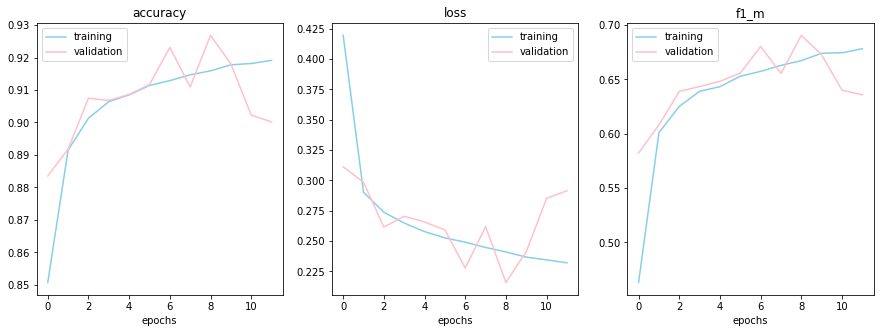

In [30]:
# Grafici koji prikazuju promene metrika tokom treniranja na trening skupu i validacionom skupu kroz epohe 

plot_graphs(binary_history, ['accuracy', 'loss', 'f1_m'])

### 6. Evaluacija modela

In [31]:
scores = binary_model.evaluate(X_test_transformed, y_test)
print('Loss: ', scores[0])
print('Test accuracy: ', scores[1])
print('F1: ', scores[2])

2305/2305 [==============================] - 7s 3ms/step - loss: 0.2910 - accuracy: 0.8999 - f1_m: 0.6091
Loss:  0.29097795486450195
Test accuracy:  0.8998914957046509
F1:  0.6090745329856873


Predviđanje: 

In [32]:
y_predicted = binary_model.predict(X_test_transformed)

In [33]:
# sigmoidna funkcija:

y_labels = [int(score > 0.5) for score in y_predicted]

In [34]:
# F1 mera je bolja metrika kada su neizbalansirane klase

print('F1: ', metrics.f1_score(y_test, y_labels))

F1:  0.6421715947649055


In [35]:
cf = metrics.confusion_matrix(y_test, y_labels)
print(cf)

[[59734  6592]
 [  790  6624]]


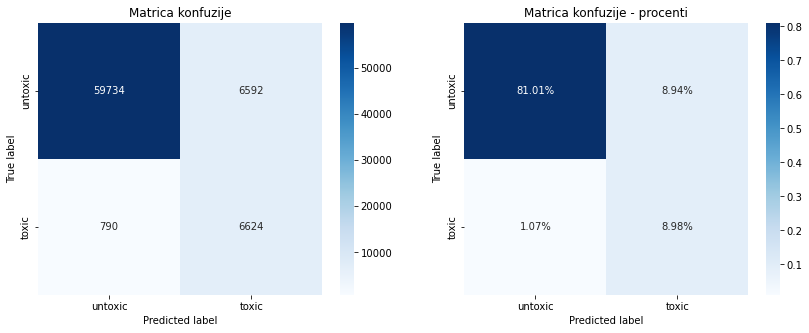

In [36]:
# funkcija koja prikazuje matricu konfuzije i 
# istu tu matricu sa vrednostima u  procentima

plot_cf(cf, 'binary', ['untoxic, toxic'])

#### - Od oko 90% procenata netoksičnih, 81.01% je tačno klasifikovano(TN), a 8.94% netačno(FP)
#### - Od oko 10% procenata toksičnih komentara, 8.98% je tačno klasifikovano(TP), a 1.07% netačno(FN)

In [37]:
print('---------------------- IZVESTAJ -----------------------\n')
print(metrics.classification_report(y_test, y_labels))

---------------------- IZVESTAJ -----------------------

              precision    recall  f1-score   support

           0       0.99      0.90      0.94     66326
           1       0.50      0.89      0.64      7414

    accuracy                           0.90     73740
   macro avg       0.74      0.90      0.79     73740
weighted avg       0.94      0.90      0.91     73740



Izdvajanje instanci na kojima model greši, i onih na kojima pogađa

In [38]:
joined = pd.concat([X_test, y_test], axis=1)
joined['predicted'] = y_labels

In [39]:
correct = joined[joined['target'] == joined['predicted']]
incorrect = joined[joined['target'] != joined['predicted']]

Primeri pogresno klasifikovanih komentara:

In [40]:
# pogresno klasifikovane instance: 
incorrect.head()

,comment_text,target,predicted
72935,possibly the worst ever adaptation of a comic ...,0,1
83588,hi i am trying to get breasts like yours but ...,0,1
132027,hornswoggle joining club hornswoggle joined ...,1,0
150714,then assert your case please do you write bu...,0,1
166794,flickrcom here are a random selection of t...,0,1


In [41]:
# FN -> toksicni koji su klasifikovani kao netoksicni
FN = (incorrect['target']==1) & (incorrect['predicted']==0)

# FP -> netoksicni koji su klasifikovani kao toksicni
FP = (incorrect['target']==0) & (incorrect['predicted']==1)

In [140]:
# incorrect[FP]['comment_text'].head()
# incorrect[FN]['comment_text'].tail()

In [180]:
indexes = incorrect[FP].index
random_index = np.random.choice(indexes)

# primer jednog nasumicnog netoksicnog koji je model obelezio kao toksican komentar

print('Primer lažno pozitivne instance: ')
incorrect[FP]['comment_text'][random_index]

Primer lažno pozitivne instance: 


'now   i still think you are doo doo  yes doo doo indeed'

In [170]:
# primer nasumicnog toksicnog koji je model obelezio kao netoksican
indexes = incorrect[FN].index
random_index = np.random.choice(indexes)

print('Primer lažno negativne instance: ')
incorrect[FN]['comment_text'][random_index]

Primer lažno negativne instance: 


'why is chris a known paedophile  still allowed to edit wikipedia'

U direktorijumu **plots and images/prediction_examples/** se nalaze skrinšotovi nekoliko zanimljivih izlaza prethodnih naredbi, 
na osnovu kojih se može zaključiti da model greši u slučaju greški u kucanju, u slučaju kada su reči napisane slovo po slovo sa razmacima između i slično. U slučaju lažno pozitivnih instanci - model predviđa komentar kao toksičan ako ima ružnih reči, a neki takvi komentari su ipak netoksični. Po mom mišljenju, neki od ovih komentara bi trebalo da budu toksični u originalnom skupu. 

Ovakvo ponašanje je očekivano, što znači da model u većini slučajeva dobro zaključuje. 

Ono što se može uraditi za bolja predviđanja je detaljnija priprema teksta, sređivanje komentara sa koji su pogrešno spelovani, spajanje u jednu reč ako ima nekoliko uzastopnih pojedinačnih slova sa razmacima izmeđi i slično.

In [137]:
# nekoliko jednostavnih provera za uvredljive, obicne komentare, namerno pogresno spelovane...
new_comments = ['fuck you bitch', 
                'fukc you', 
                'hello i have a question about something', 
                'shit head', 
                'shithead',
                'this is a clean comment', 
                'get out of here']

new = to_sequence(new_comments, 100, tokenizer)

In [138]:
# verovatnoce pripadanja toksicnim:

probs = binary_model.predict(new)

toxic_probs = {}
i = 0
for comment in new_comments:
    toxic_probs[comment] = probs[i][0]
    i += 1

In [139]:
toxic_probs

{'fuck you bitch': 0.9989043,
 'fukc you': 0.5652397,
 'hello i have a question about something': 0.20029521,
 'shit head': 0.9964296,
 'shithead': 0.26495153,
 'this is a clean comment': 0.20271212,
 'get out of here': 0.4103075}

Od ovih primera, model pogrešno predviđa jedino za dva komentara koja su pogrešno napisana, pa se za njih ne može zaključiti da su u pitanju uvredljive reči. 

### Čuvanje modela

In [181]:
binary_model.save('models/binary_model.h5')

In [ ]:
# model = keras.models.load_model('models/binary_model.h5', custom_objects={"f1_m": f1_m})

In [ ]:
# model.get_config()